# ProtVI

In [41]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch

import data_support as sup
from scp.models import PROTVI
import scp.plots as pl
import scp.utils as utils
import scp.metrics as metrics
import scp.simulations as sm
from scp.benchmark_models import run_protDP

import scvi

np.random.seed(0)
torch.manual_seed(0)
scvi.settings.seed = 0

Global seed set to 0


Let"s load the data.

In [42]:
adata = sc.read_h5ad("../../data/processed/manns_inhouse.h5ad")

##  Mask-and-impute experiments

In [43]:
m_mnar, m_mcar = sm.create_mnar_mcar_mask(mv_rate=0.05, mnar_proportion=1, x=adata.layers["main"], seed=42)

In [44]:
print(f"MNAR: {np.sum(m_mnar) / m_mnar.size:.3f}, MCAR: {np.sum(m_mcar) / m_mcar.size:.3f}")

MNAR: 0.035, MCAR: 0.000


In [45]:
def plot_mnar_ratio(adata, m_mnar):
    bins = np.linspace(np.nanmin(adata.X), np.nanmax(adata.X), num=30)

    x1 = adata.X[m_mnar]
    hist1, edges1 = np.histogram(x1, bins=bins)

    x2 = adata.X[~np.isnan(adata.X)]
    hist2, _ = np.histogram(x2, bins=bins)

    normalized = hist1 / hist2

    fig, ax = plt.subplots()
    ax.bar(edges1[:-1], normalized, width=np.diff(edges1), align="edge", edgecolor="black")
    ax.set_xlabel("Protein expression")
    ax.set_ylabel("MNAR / observed")
    ax.set_title("MNAR / observed ratio")
    ax.grid(True)
    ax.set_axisbelow(True)

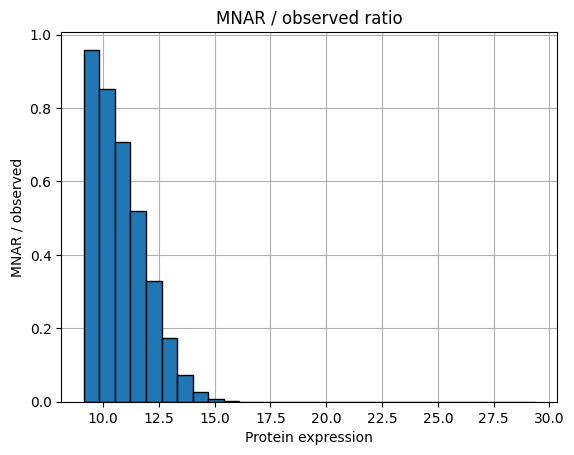

In [46]:
plot_mnar_ratio(adata, m_mnar)

In [47]:
train_mask = ~(m_mcar | m_mnar)

sm.add_train_test_set(adata, train_mask, layer="main")

## PROTVI

### Training

Let's now train the model.

In [48]:
adata.X = adata.layers["train"].copy()
adata.X[np.isnan(adata.X)] = 0

In [49]:
PROTVI.setup_anndata(adata, batch_key="Plate")#, continuous_covariate_keys=["log Qalb"])

model = PROTVI(adata, log_variational=False, decoder_type="selection", max_loss_dropout=0)
#model.view_anndata_setup()

Let's train the model.

In [50]:
model.train(max_epochs=1800, plan_kwargs={"mechanism_weight": 1}, check_val_every_n_epoch=1) #, plan_kwargs={"min_kl_weight": 8, "max_kl_weight": 8})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1800/1800: 100%|██████████| 1800/1800 [29:37<00:00,  1.16s/it, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.29e+3]

`Trainer.fit` stopped: `max_epochs=1800` reached.


Epoch 1800/1800: 100%|██████████| 1800/1800 [29:37<00:00,  1.01it/s, v_num=1, train_loss_step=1.48e+3, train_loss_epoch=1.29e+3]


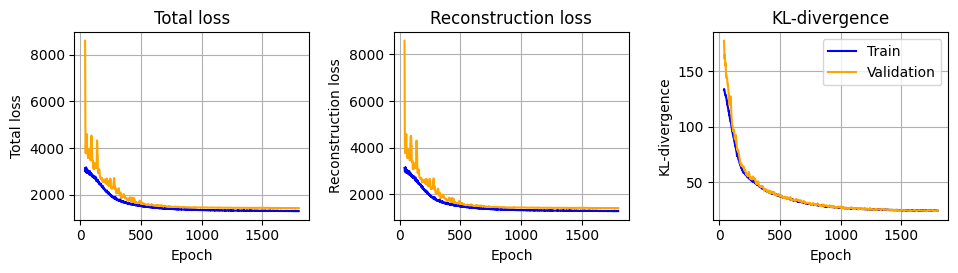

In [51]:
pl.plot_loss(model.history, epoch_start=40, validation_smooth_window=10)

In [52]:
#model.save("protvi_baseline_mcar")

### Evaluation on training set (MAIN)

In [53]:
x_est, p_est = model.impute(n_samples=10)

x_main = adata.layers["main"]
x_pilot = adata.layers["pilot"]

x_est_obs = x_est.copy()
x_est_obs[np.isnan(x_main)] = np.nan

x_est_miss = x_est.copy()
x_est_miss[~np.isnan(x_main)] = np.nan

In [54]:
x_test = adata.layers["test"]

x_guess = x_est[~np.isnan(x_test)]
x_true = x_test[~np.isnan(x_test)]

mse_test = metrics.mse(x_guess, x_true)

print(f"Test MSE: {mse_test:.4f}")

Test MSE: 0.2874
